In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Networks 
## Session 13a

## Multiple Hidden Layers
## Simulating over fitting
## Dropout

<img src='../../prasami_images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
###-----------------
### Import Libraries
###-----------------

import os

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from sklearn import datasets

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [3]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../../input'
outDir = '../output'
modelDir = '../models'
subDir = 'fifa_2019'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 50001 # number of cycles to run

ALPHA = 0.1 # learning rate

# Set parameters for decoration of plots
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params) # update rcParams

## Generate Data Set
<p style="font-family: Arial; font-size:1.2em">
Use Sklearn's dataset generator <a href="http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html">make_moon</a> dataset generator.
</p>

In [4]:
X, y = datasets.make_moons(n_samples=1280, shuffle=True, noise=0.2, random_state=RANDOM_STATE)

In [6]:
def fn_plot_decision_boundary(pred_func, X, y):
    '''
        Attrib:
           pred_func : function based on predict method of the classifier
           X : feature matrix
           y : targets
       Return:
           None           
    '''
    
    # Set min and max values and give it some padding
    xMin, xMax = X[:, 0].min() - .05, X[:, 0].max() + .05
    yMin, yMax = X[:, 1].min() - .05, X[:, 1].max() + .05
    
    # grid size for mesh grid
    h = 0.01
    
    # Generate a grid of points with distance 'h' between them
    xx, yy = np.meshgrid(np.arange(xMin, xMax, h), np.arange(yMin, yMax, h))
    
    # Predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    
    # Make its shape same as that of xx 
    Z = Z.reshape(xx.shape)
    
    # Now we have Z value corresponding to each of the combination of xx and yy
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=CMAP)
    
    # plot the points as well
    plt.scatter(X[:, 0], X[:, 1], c=np.argmax(y, axis =1), s=20, cmap=CMAP, edgecolors='black')

In [7]:
y = pd.get_dummies(y).values
y

array([[False,  True],
       [ True, False],
       [False,  True],
       ...,
       [ True, False],
       [False,  True],
       [ True, False]])

In [8]:
#  Split the data in training and test sets to measure performance of the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE )

print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1024, 2) (1024, 2) (256, 2) (256, 2)


# Neural Network

## Multiple hidden layers

<p style="font-family: Arial; font-size:1.2em;"> 
    Moving over to multilayer network. Our data has <strong>two</strong> features. Hence size of input layer will also be two. The output is binary, we can code it as single column as well as double column output. Let's consider following hidden layers:</p>
<table style="font-family: Arial; font-size:1.2em;">
    <tr>
        <th>#</th>
        <th>Layer Number</th>
        <th>Nodes </th>
        <th>Activation </th>
    </tr>
    <tr>
        <td>1</td>
        <td>Input Layer</td>
        <td>2</td>
        <td>tanh</td>
    </tr>
    <tr>
        <td>2</td>
        <td>Hidden Layer 1</td>
        <td>5</td>
        <td>tanh</td>
    </tr>
    <tr>
        <td>3</td>
        <td>Hidden Layer 2</td>
        <td>5</td>
        <td>tanh</td>
    </tr>
    <tr>
        <td>4</td>
        <td>Hidden Layer 3</td>
        <td>4</td>
        <td>tanh</td>
    </tr>
    <tr>
        <td>5</td>
        <td>Hidden Layer 4</td>
        <td>3</td>
        <td>tanh</td>
    </tr>
    <tr>
        <td>6</td>
        <td>Layer 5 (Output)</td>
        <td>2</td>
        <td>softmax</td>
    </tr>
</table>

In [9]:
def fn_softmax(z):
    
    '''
    Args:
        z : a matrix of z values of shape (m, n_output)
    returns:
        Softmax values of z
    
    '''
    exp_scores = np.exp( z - np.max(z) )

    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

In [10]:
def fn_actv(z):
    '''
    Args:
        z: array
    Returns:
        z: array
    '''
    return np.tanh(z)

def fn_actv_prime(a):
    '''
    Args:
        a: array
    Returns:
        a: array
    '''
        
    return (1 - np.power(a, 2))

## Calculate Loss Function
<p style="font-family: Arial; font-size:1.2em;">
Calculate loss by forward propagation</p>

In [11]:
# Helper function to evaluate the total loss on the dataset

def calculate_loss(model, X_l, y_l):
    
    # Extract weights and losses from the model
    W1, W2, W3, W4, W5 = model['W1'], model['W2'], model['W3'], model['W4'], model['W5']
    b1, b2, b3, b4, b5 = model['b1'], model['b2'], model['b3'], model['b4'], model['b5']
    m = X_l.shape[0]
    # Layer 1
    z1 = X_l.dot(W1) + b1  # Aggregation
    a1 = fn_actv(z1)     # Activation

    # Layer 2
    z2 = a1.dot(W2) + b2 # Aggregation
    a2 = fn_actv(z2)     # Activation

    # Layer 3
    z3 = a2.dot(W3) + b3 # Aggregation
    a3 = fn_actv(z3)     # Activation
   
    # Layer 4
    z4 = a3.dot(W4) + b4 # Aggregation
    a4 = fn_actv(z4)     # Activation
   
    # Layer 5
    z5 = a4.dot(W5) + b5 # Aggregation
    a5 = fn_softmax(z5)  # softmax activation
    
    # Calculating the loss
    data_loss = -(y_l * np.log(a5) + (1 - y_l) * np.log(1 - a5) ).sum() 

    return data_loss / m

## Predict Function
<p style="font-family: Arial; font-size:1.2em;">
For predictions, we will simply be using the forward propagation. No need to iterate or calculate the back propogation for supervised learning.
</p>

In [12]:
# Helper function to predict an output (0 or 1)

def predict(model, X):
    '''
     Args:
         model : Dictionary object containing Weights and Biases
         X: input features
    '''
    # Extract weights and losses from the model
    W1, W2, W3, W4, W5 = model['W1'], model['W2'], model['W3'], model['W4'], model['W5']
    b1, b2, b3, b4, b5 = model['b1'], model['b2'], model['b3'], model['b4'], model['b5']
    
    #***********************************
    # Layer 1
    z1 = X.dot(W1) + b1 
    a1 = fn_actv(z1)    # activation
    
    # Layer 2
    z2 = a1.dot(W2) + b2 
    a2 = fn_actv(z2)    # activation
    
    # Layer 3
    z3 = a2.dot(W3) + b3 
    a3 = fn_actv(z3)    # activation
    
    # Layer 4
    z4 = a3.dot(W4) + b4 
    a4 = fn_actv(z4)    # activation
    
    # Layer 5
    z5 = a4.dot(W5) + b5
    a5 = fn_softmax(z5)# use softmax
    
    return np.argmax(a5, axis=1) # pick with one with highest probabilities

## Forward Propogation

<img src='../../images/dnn_nb_s12_fig1.png' style='width: 800px' alt = 'Session 12 Figure 1'/>
<hr>
<img src='../../images/dnn_nb_s12_fig2.png' style='width: 800px' alt = 'Session 12 Figure 2'/>
<hr>
<img src='../../images/dnn_nb_s12_fig3.png' style='width: 800px' alt = 'Session 12 Figure 2'/>

### Why should it work?
- We are simplifying the network by removing a few nodes.
- Recall that eventually every node starts focusing on some pattern more than others. By randomly disabling the nodes, we are reducing over dependence.

###  Implementation of Dropout
In drop out, we are removing some of the nodes resulting in the forward propagation being carried out by lesser nodes. It will inflate weights of remaining nodes in each layer. To keep it under check, we divide Activations by `keep_prob` (keep probability i.e. artificially inflate activations) to keep weights correct.<br><br>

Similarly we will also divide $\partial{A}$ by `keep_prob`.


In [13]:
def drop_out_forward(A, keep_prob):
    '''
    Args:
        A: Activation matrix
        keep_prob: probabiity of keeping the nodes 0 < keep_prob < 1
        cache : to keep all parameters to be cached
    '''
    
    
    # Implementing drop-outs
    if keep_prob > 0:
        
        drop_out = np.random.rand(A.shape[0], A.shape[1])
        
        drop_out = (drop_out < keep_prob).astype(float)
        
        A *= drop_out # makes the nodes 0.0
        
        A /= keep_prob # Adjustment so that the weights do not over inflate
    
    return A, drop_out

## How drop_out_forward works
<div class= 'alert alert-block alert-info' style="font-family: Arial; font-size:1.2em;" > Create matrix of same size as activations of the layer. Fill it with random numbers.<div>

In [14]:
dropout = np.random.rand(5, 4).round(2)
print (dropout)

[[0.96 0.7  1.   0.22]
 [0.36 0.74 1.   0.32]
 [0.14 0.38 0.32 0.37]
 [0.71 0.9  0.53 0.25]
 [0.67 0.56 0.54 0.89]]


In [15]:
print (dropout.max(), dropout.min())

1.0 0.14


<div class= 'alert alert-block alert-info' style="font-family: Arial; font-size:1.2em;" > Any thing above keep probability (0.75) will be set to zero...<div>

In [16]:
dropout = (dropout < 0.75).astype(float)
print (dropout)

[[0. 1. 0. 1.]
 [1. 1. 0. 1.]
 [1. 1. 1. 1.]
 [1. 0. 1. 1.]
 [1. 1. 1. 0.]]


In [17]:
def drop_out_back(dA, drop_out, keep_prob):
    '''
    Args:
        dA : Back-propagation activations
        drop_out: dropout activations calculated during forward propagation
        keep_prob: probability of keeping a node.
    Returns:
        Modified activations adjusted for the dropouts
    '''
    # Implementing drop-outs
    if keep_prob > 0:
        
        dA *= drop_out
        
        dA /= keep_prob
    
    return dA

In [18]:
# prepare the Model

def build_model(param, X, y, X_t, y_t, keep_prob,
                epochs=20000,
                alpha = ALPHA):
    
    '''
       nn_hdim : Number of nodes in the hidden layer
        X   : Features to train on
        y   : Targets to train on
        X_t : Features to test
        y_t : Targets to test
        num_passes : Number of passes through the training data for gradient descent
        print_loss : If True, print the loss every 1000 iterations
    '''
    # set Random Seed
    np.random.seed(RANDOM_STATE) # since we will be creating two models with in this sheet.
    
    m = X.shape[0] # number of training examples
    nn_output_dim = y.shape[1] # output layer dimensionality
    
    # Dropout
    cache = {} # to retain all values to be cached
    
    # Initialize the parameters to random values. We need to learn these.
    W1 = np.random.randn(param['nn_hdim'][0], param['nn_hdim'][1]) / np.sqrt(param['nn_hdim'][0])
    b1 = np.zeros((1, param['nn_hdim'][1]))
    
    W2 = np.random.randn(param['nn_hdim'][1], param['nn_hdim'][2]) / np.sqrt(param['nn_hdim'][1])
    b2 = np.zeros((1, param['nn_hdim'][2]))
    
    W3 = np.random.randn(param['nn_hdim'][2], param['nn_hdim'][3]) / np.sqrt(param['nn_hdim'][2])
    b3 = np.zeros((1, param['nn_hdim'][3]))
    
    W4 = np.random.randn(param['nn_hdim'][3], param['nn_hdim'][4]) / np.sqrt(param['nn_hdim'][3])
    b4 = np.zeros((1, param['nn_hdim'][4]))
   
    W5 = np.random.randn(param['nn_hdim'][4], nn_output_dim) / np.sqrt(param['nn_hdim'][4])
    b5 = np.zeros((1, nn_output_dim))

    model = {}
    
    assert (W1.shape == tuple(param['nn_hdim'][0:2])), 'Incorrect shape of W1 :{}'.format(W1.shape)
    
    curr_loss = 0
    ct_loss = 0
    loss = []
    epoch = []
    t_loss = []
    
    # Gradient descent. For each batch...
    for i in range(0, epochs):

        # Layer 1
        z1 = X.dot(W1) + b1 # aggregation
        a1 = fn_actv(z1)    # activation

        #################
        ###  Dropout  ###
        #################
        a1, drop_out1 = drop_out_forward(a1, keep_prob)
        cache['a1_dropout'] = drop_out1
        assert (z1.shape == a1.shape),"Shape of z1 and a1 do not match"
        
        # Layer 2
        z2 = a1.dot(W2) + b2 # aggregation
        a2 = fn_actv(z2)     # activation

        #################
        ###  Dropout  ###
        #################
        a2, drop_out2 = drop_out_forward(a2, keep_prob) # Dropout
        cache['a2_dropout'] = drop_out2
        assert (z2.shape == a2.shape),"Shape of z2 and a2 do not match"
        
        # Layer 3
        z3 = a2.dot(W3) + b3 # aggregation
        a3 = fn_actv(z3)     # activation
 
        #################
        ###  Dropout  ###
        #################
        a3,drop_out3 = drop_out_forward(a3, keep_prob) # Dropout
        cache['a3_dropout'] = drop_out3
        assert (z3.shape == a3.shape),"Shape of z3 and a3 do not match"

        # Layer 4
        z4 = a3.dot(W4) + b4 # aggregation
        a4 = fn_actv(z4)     # activation

        #################
        ###  Dropout  ###
        #################
        a4, drop_out4 = drop_out_forward(a4, keep_prob) # Dropout
        cache['a4_dropout'] = drop_out4
        assert (z4.shape == a4.shape),"Shape of z4 and a4 do not match"

        # Layer 5
        z5 = a4.dot(W5) + b5
        a5 = fn_softmax(z5)

        
        #Backpropagation        
        # Layer 5
        dz5 = a5 -y
        
        dW5 = (a4.T).dot(dz5)
        db5 = np.sum(dz5, axis=0, keepdims=True) # db5 is vertical sum of delta5
        da4 = dz5.dot(W5.T)

        #################
        ###  Dropout  ###
        #################
        da4 = drop_out_back(da4, cache['a4_dropout'], keep_prob) ## drop_layer
        assert (dW5.shape == W5.shape),"Shape of dW5 {} and W5 {} do not match".format(dW5.shape, W5.shape)
        assert (da4.shape == a4.shape),"Shape of da4 {} and a4 {} do not match".format(da4.shape, a4.shape)
        
        # Layer 4
        dz4 = da4 * fn_actv_prime(a4)        
        dW4 = (a3.T).dot(dz4)
        assert (dW4.shape == W4.shape),"Shape of dW4 {} and W4 {} do not match".format(dW4.shape, W4.shape)
        assert (dz4.shape == z4.shape),"Shape of dz4 {} and z4{} do not match".format(dz4.shape, z4.shape)
        
        db4 = np.sum(dz4, axis=0, keepdims=True)
        da3= dz4.dot(W4.T)
        
        #################
        ###  Dropout  ###
        #################
        da3 = drop_out_back(da3, cache['a3_dropout'], keep_prob) ## drop_layer
        assert (da3.shape == a3.shape),"Shape of da3 {} and a3 {} do not match".format(da3.shape, a3.shape)

        # Layer 3
        dz3 = da3 * fn_actv_prime(a3)        
        dW3 = (a2.T).dot(dz3)
        assert (dW3.shape == W3.shape),"Shape of dW3 {} and W3 {} do not match".format(dW3.shape, W3.shape)
        assert (dz3.shape == z3.shape),"Shape of dz3 {} and z3{} do not match".format(dz3.shape, z3.shape)
        
        db3 = np.sum(dz3, axis=0, keepdims=True)
        da2= dz3.dot(W3.T)
        
        #################
        ###  Dropout  ###
        #################
        da2 = drop_out_back(da2, cache['a2_dropout'], keep_prob) ## drop_layer
            
        assert (da2.shape == a2.shape),"Shape of da2 {} and a2 {} do not match".format(da2.shape, a2.shape)

        # Layer 2 
        dz2 = da2 * fn_actv_prime(a2)
        dW2 = (a1.T).dot(dz2)
        assert (dW2.shape == W2.shape),"Shape of dW2 {} and W2 {} do not match".format(dW2.shape, W2.shape)
        assert (dz2.shape == z2.shape),"Shape of dz2 {} and z2{} do not match".format(dz2.shape, z2.shape)
        
        db2 = np.sum(dz2, axis=0, keepdims=True)
        da1= dz2.dot(W2.T)
        
        #################
        ###  Dropout  ###
        #################
        da1 = drop_out_back(da1, cache['a1_dropout'], keep_prob) ## drop_layer
        assert (da1.shape == a1.shape),"Shape of da1 {} and a1 {} do not match".format(da1.shape, a1.shape)

        # Layer 1
        dz1 = da1 * fn_actv_prime(a1)
        assert (dz1.shape == z1.shape),"Shape of dz1 {} and z1{} do not match".format(dz1.shape, z1.shape)
        
        dW1 = (X.T).dot(dz1)
        assert (dW1.shape == W1.shape),"Shape of dW2 {} and W2 {} do not match".format(dW2.shape, W2.shape)
        
        db1 = np.sum(dz1, axis=0, keepdims=True)
        assert (db1.shape == b1.shape),"Shape of db1 {} and b1 {} do not match".format(db1.shape, b1.shape)

        
        # Gradient descent parameter update
        W1 += -alpha * dW1 / m 
        b1 += -alpha * db1 / m 
        
        W2 += -alpha * dW2 / m 
        b2 += -alpha * db2 / m 
        
        W3 += -alpha * dW3 / m 
        b3 += -alpha * db3 / m 
        
        W4 += -alpha * dW4 / m 
        b4 += -alpha * db4 / m 
        
        W5 += -alpha * dW5 / m 
        b5 += -alpha * db5 / m 
        
        # Assign new parameters to the model
        model = { 
            'W1': W1, 'b1': b1,
            'W2': W2, 'b2': b2,
            'W3': W3, 'b3': b3,
            'W4': W4, 'b4': b4,
            'W5': W5, 'b5': b5,}
        
        # Print the loss.
        if i % 10 == 0:
            curr_loss = calculate_loss(model, X, y)
            loss.append(curr_loss)
            ct_loss = calculate_loss(model, X_t, y_t)
            t_loss.append(ct_loss)
            epoch.append(i)

        # Print the loss.
        if i % 1000 == 0:
            print("Loss after iteration %i: %f, %f" %(i, curr_loss, ct_loss))
            
    loss_hist['epoch'] = epoch
    loss_hist['Loss'] = loss
    loss_hist['Test_loss'] = t_loss
    
    return model

In [19]:
# define nodes in each of dims
layer_param = {}
layer_param['nn_hdim'] = [X_train.shape[1],20,20,16,3,2]
keep_prob = 1.0

loss_hist = {}

In [20]:
num_examples = len(X_train) # training set size

nn_output_dim = 2 

# Build a model
model = build_model(layer_param, X_train, y_train, X_test, y_test, epochs = EPOCHS, alpha = ALPHA, keep_prob = keep_prob)

Loss after iteration 0: 1.356687, 1.356573
Loss after iteration 1000: 0.151599, 0.188710
Loss after iteration 2000: 0.139273, 0.187299
Loss after iteration 3000: 0.134820, 0.187573
Loss after iteration 4000: 0.132296, 0.189315
Loss after iteration 5000: 0.129827, 0.192241
Loss after iteration 6000: 0.127548, 0.195530
Loss after iteration 7000: 0.125554, 0.199510
Loss after iteration 8000: 0.123760, 0.205008
Loss after iteration 9000: 0.122069, 0.211973
Loss after iteration 10000: 0.120328, 0.219410
Loss after iteration 11000: 0.118352, 0.225686
Loss after iteration 12000: 0.116210, 0.230183
Loss after iteration 13000: 0.114207, 0.233579
Loss after iteration 14000: 0.112369, 0.235385
Loss after iteration 15000: 0.110414, 0.234747
Loss after iteration 16000: 0.108389, 0.233238
Loss after iteration 17000: 0.106537, 0.232346
Loss after iteration 18000: 0.104891, 0.232079
Loss after iteration 19000: 0.103348, 0.232211
Loss after iteration 20000: 0.101837, 0.232776
Loss after iteration 21000

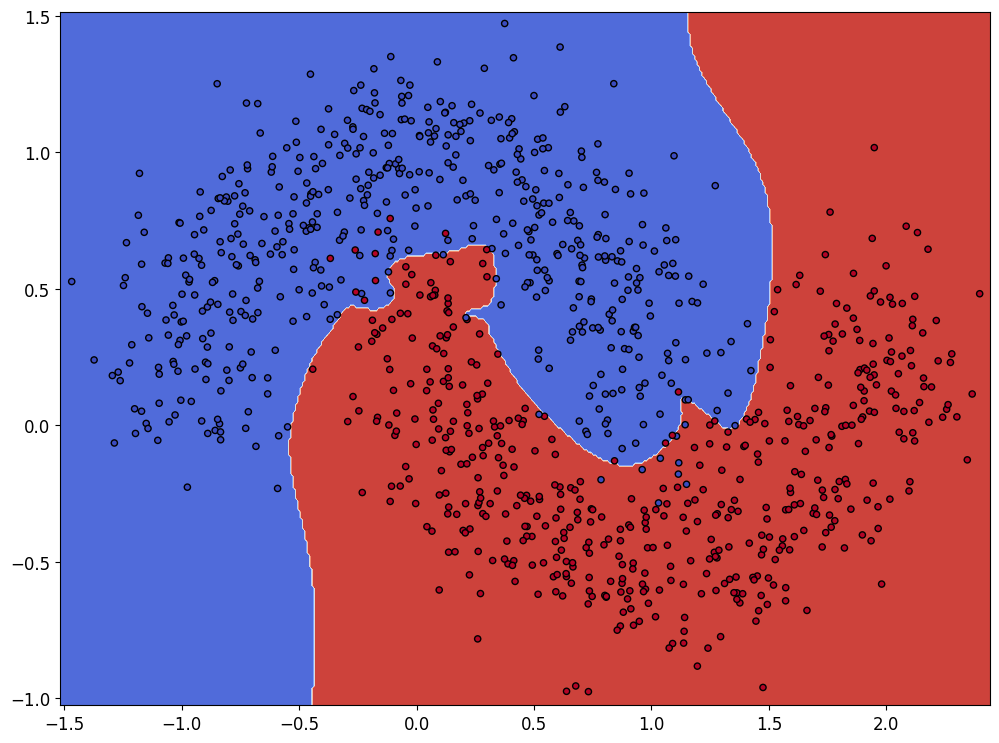

In [21]:
loss_df = pd.DataFrame(loss_hist)
fn_plot_decision_boundary(lambda x: predict(model, x), X_train, y_train) # plot decision boundary for this plot

In [22]:
def fn_make_predicitions(pred_func, X):
    y_pred = pred_func(X)
    return y_pred

In [23]:
y_pred = fn_make_predicitions(lambda x: predict(model, x), X_train)
print('Accruacy score on Train Data :', accuracy_score(np.argmax(y_train, axis = 1), y_pred))
print (confusion_matrix(np.argmax(y_train, axis = 1), y_pred))

Accruacy score on Train Data : 0.97265625
[[508  14]
 [ 14 488]]


In [24]:
y_pred = fn_make_predicitions(lambda x: predict(model, x), X_test)

print('Accruacy score on Test Data :', accuracy_score(np.argmax(y_test, axis = 1), y_pred))
print (confusion_matrix(np.argmax(y_test, axis = 1), y_pred))

Accruacy score on Test Data : 0.94921875
[[110   8]
 [  5 133]]


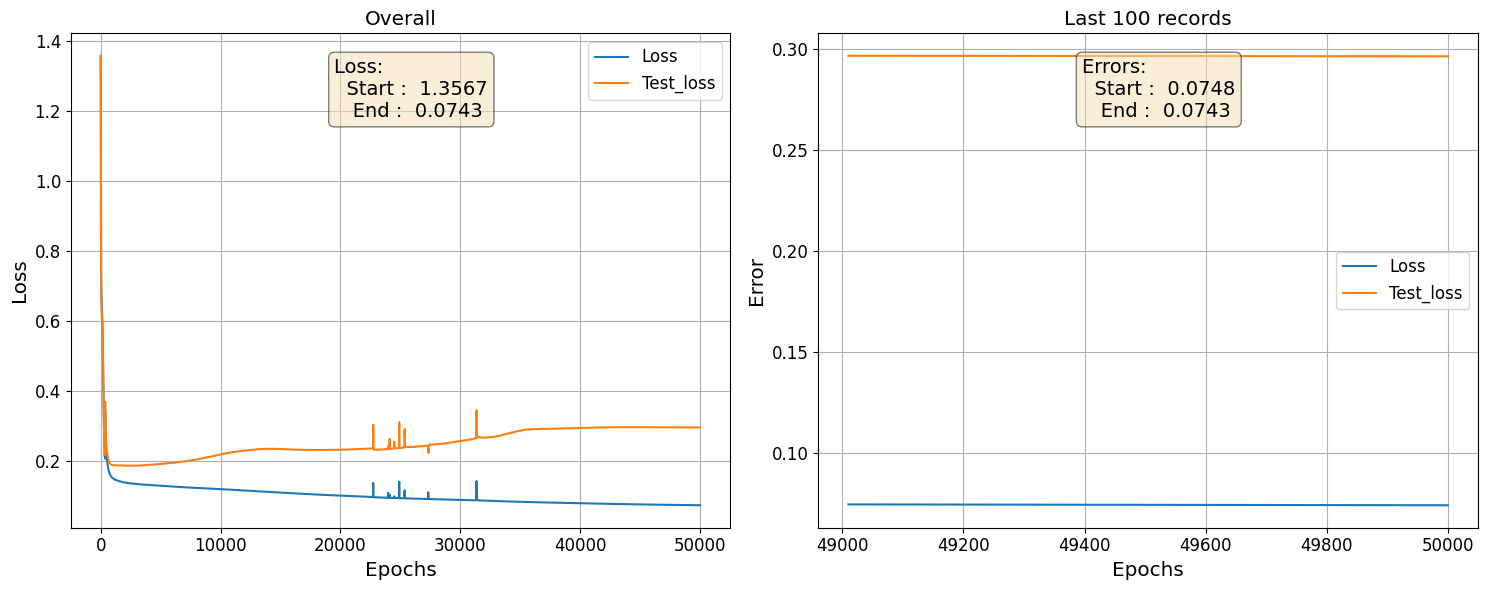

In [25]:
loss_df = pd.DataFrame(loss_hist)

fig, axes = plt.subplots(1,2 , figsize = (15,6))

l_range = 100

ax = axes[0]

loss_df.plot(x = 'epoch', y = ['Loss', 'Test_loss'], ax = ax)
loss = loss_df['Loss'].values

# little beautification
txtstr = "Loss: \n  Start : {:7.4f}\n   End : {:7.4f}".format(loss[0],loss[-1]) #text to plot
# properties  matplotlib.patch.Patch 
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords

ax.text(0.4, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_title('Overall')
ax.grid()

ax = axes[1]

loss_df[-l_range:].plot(x = 'epoch', y = ['Loss', 'Test_loss'], ax = ax)

# little beautification
txtstr = "Errors: \n  Start : {:7.4f}\n   End : {:7.4f}".format(loss[-l_range],loss[-1]) #text to plot
# properties  matplotlib.patch.Patch 
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords

ax.text(0.4, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Error")
ax.set_title('Last {} records'.format(l_range))
ax.grid()
plt.tight_layout();

## Rerun the model with 90% keep prob

In [26]:
keep_prob = 0.90
# Build a model 
model = build_model(layer_param, X_train, y_train, X_test, y_test, epochs = EPOCHS, alpha = ALPHA, keep_prob = keep_prob)

Loss after iteration 0: 1.359435, 1.359316
Loss after iteration 1000: 0.210976, 0.219511
Loss after iteration 2000: 0.154653, 0.179186
Loss after iteration 3000: 0.151934, 0.185705
Loss after iteration 4000: 0.150244, 0.191584
Loss after iteration 5000: 0.147629, 0.194598
Loss after iteration 6000: 0.145871, 0.198815
Loss after iteration 7000: 0.144043, 0.194925
Loss after iteration 8000: 0.142500, 0.197040
Loss after iteration 9000: 0.141812, 0.200935
Loss after iteration 10000: 0.140924, 0.202583
Loss after iteration 11000: 0.141222, 0.207005
Loss after iteration 12000: 0.139949, 0.197251
Loss after iteration 13000: 0.139645, 0.206170
Loss after iteration 14000: 0.138717, 0.203461
Loss after iteration 15000: 0.138267, 0.199290
Loss after iteration 16000: 0.139303, 0.196924
Loss after iteration 17000: 0.137715, 0.196475
Loss after iteration 18000: 0.136983, 0.199842
Loss after iteration 19000: 0.136926, 0.195342
Loss after iteration 20000: 0.136441, 0.200557
Loss after iteration 21000

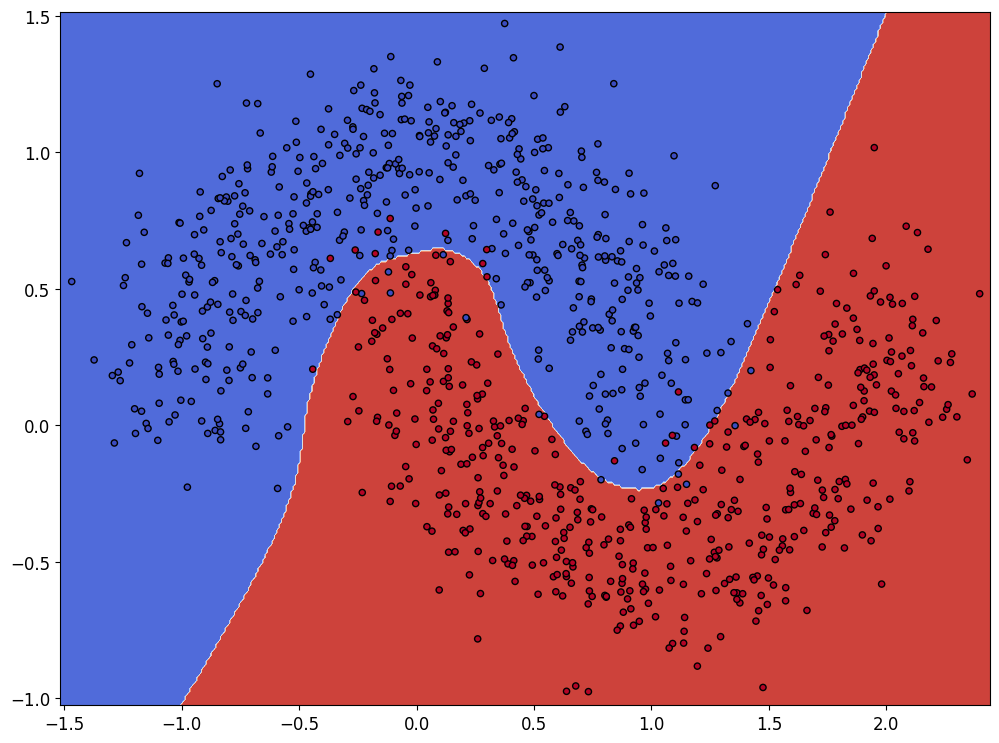

In [27]:
loss_df = pd.DataFrame(loss_hist)
fn_plot_decision_boundary(lambda x: predict(model, x), X_train, y_train) # plot decision boundary for this plot

In [28]:
y_pred = fn_make_predicitions(lambda x: predict(model, x), X_train)
print('Accruacy score on Train Data :', accuracy_score(np.argmax(y_train, axis = 1), y_pred))
print (confusion_matrix(np.argmax(y_train, axis = 1), y_pred))

Accruacy score on Train Data : 0.9716796875
[[510  12]
 [ 17 485]]


In [29]:
y_pred = fn_make_predicitions(lambda x: predict(model, x), X_test)

print('Accruacy score on Test Data :', accuracy_score(np.argmax(y_test, axis = 1), y_pred))
print (confusion_matrix(np.argmax(y_test, axis = 1), y_pred))

Accruacy score on Test Data : 0.9609375
[[115   3]
 [  7 131]]


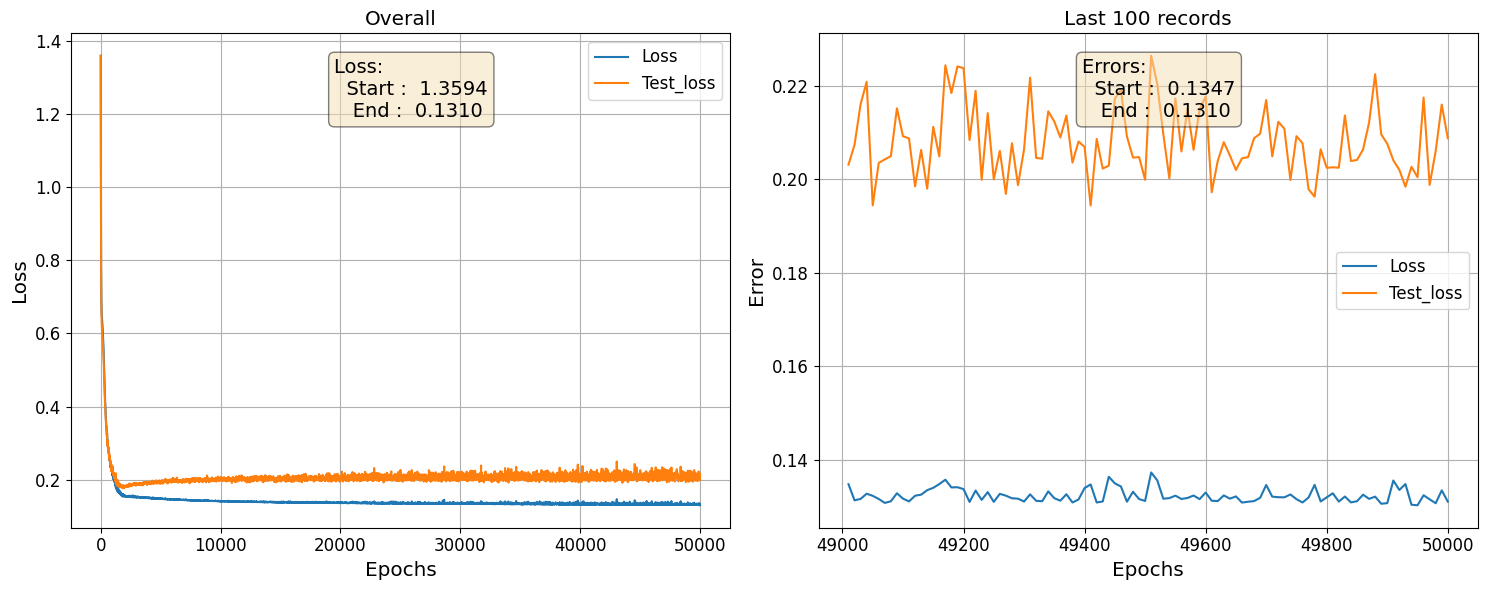

In [30]:
loss_df = pd.DataFrame(loss_hist)

fig, axes = plt.subplots(1,2 , figsize = (15,6))

l_range = 100

ax = axes[0]

loss_df.plot(x = 'epoch', y = ['Loss', 'Test_loss'], ax = ax)
loss = loss_df['Loss'].values

# little beautification
txtstr = "Loss: \n  Start : {:7.4f}\n   End : {:7.4f}".format(loss[0],loss[-1]) #text to plot
# properties  matplotlib.patch.Patch 
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords

ax.text(0.4, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_title('Overall')
ax.grid()

ax = axes[1]

loss_df[-l_range:].plot(x = 'epoch', y = ['Loss', 'Test_loss'], ax = ax)

# little beautification
txtstr = "Errors: \n  Start : {:7.4f}\n   End : {:7.4f}".format(loss[-l_range],loss[-1]) #text to plot
# properties  matplotlib.patch.Patch 
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords

ax.text(0.4, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Error")
ax.set_title('Last {} records'.format(l_range))
ax.grid()
plt.tight_layout();

In [31]:
keep_prob = 0.95
# Build a model 
model = build_model(layer_param, X_train, y_train, X_test, y_test, epochs = EPOCHS, alpha = ALPHA, keep_prob = keep_prob)

Loss after iteration 0: 1.357822, 1.357713
Loss after iteration 1000: 0.173306, 0.189959
Loss after iteration 2000: 0.149778, 0.177200
Loss after iteration 3000: 0.145594, 0.183542
Loss after iteration 4000: 0.144828, 0.186098
Loss after iteration 5000: 0.144212, 0.191093
Loss after iteration 6000: 0.141796, 0.189313
Loss after iteration 7000: 0.140428, 0.189378
Loss after iteration 8000: 0.139528, 0.194079
Loss after iteration 9000: 0.138802, 0.197350
Loss after iteration 10000: 0.137967, 0.195417
Loss after iteration 11000: 0.137599, 0.196982
Loss after iteration 12000: 0.137492, 0.194859
Loss after iteration 13000: 0.136139, 0.197421
Loss after iteration 14000: 0.135515, 0.197832
Loss after iteration 15000: 0.135152, 0.197013
Loss after iteration 16000: 0.135599, 0.194806
Loss after iteration 17000: 0.134660, 0.195507
Loss after iteration 18000: 0.134257, 0.197723
Loss after iteration 19000: 0.133647, 0.194100
Loss after iteration 20000: 0.133271, 0.199659
Loss after iteration 21000

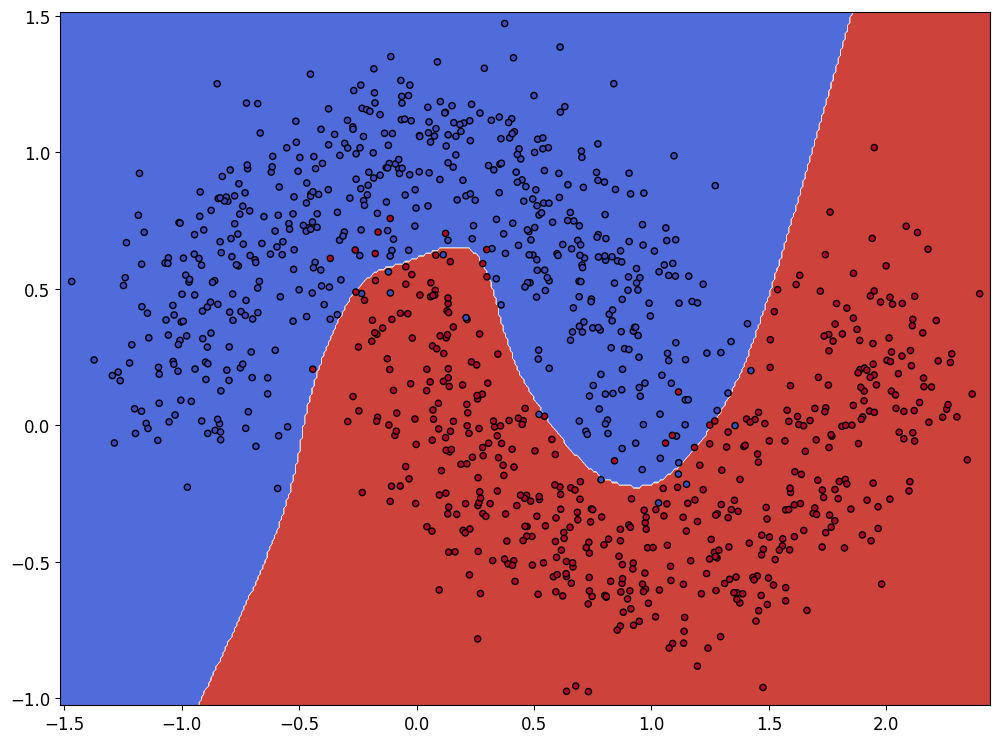

In [32]:
loss_df = pd.DataFrame(loss_hist)
fn_plot_decision_boundary(lambda x: predict(model, x), X_train, y_train) # plot decision boundary for this plot

In [33]:
y_pred = fn_make_predicitions(lambda x: predict(model, x), X_train)
print('Accruacy score on Train Data :', accuracy_score(np.argmax(y_train, axis = 1), y_pred))
print (confusion_matrix(np.argmax(y_train, axis = 1), y_pred))

Accruacy score on Train Data : 0.97265625
[[510  12]
 [ 16 486]]


In [34]:
y_pred = fn_make_predicitions(lambda x: predict(model, x), X_test)

print('Accruacy score on Test Data :', accuracy_score(np.argmax(y_test, axis = 1), y_pred))
print (confusion_matrix(np.argmax(y_test, axis = 1), y_pred))

Accruacy score on Test Data : 0.95703125
[[114   4]
 [  7 131]]


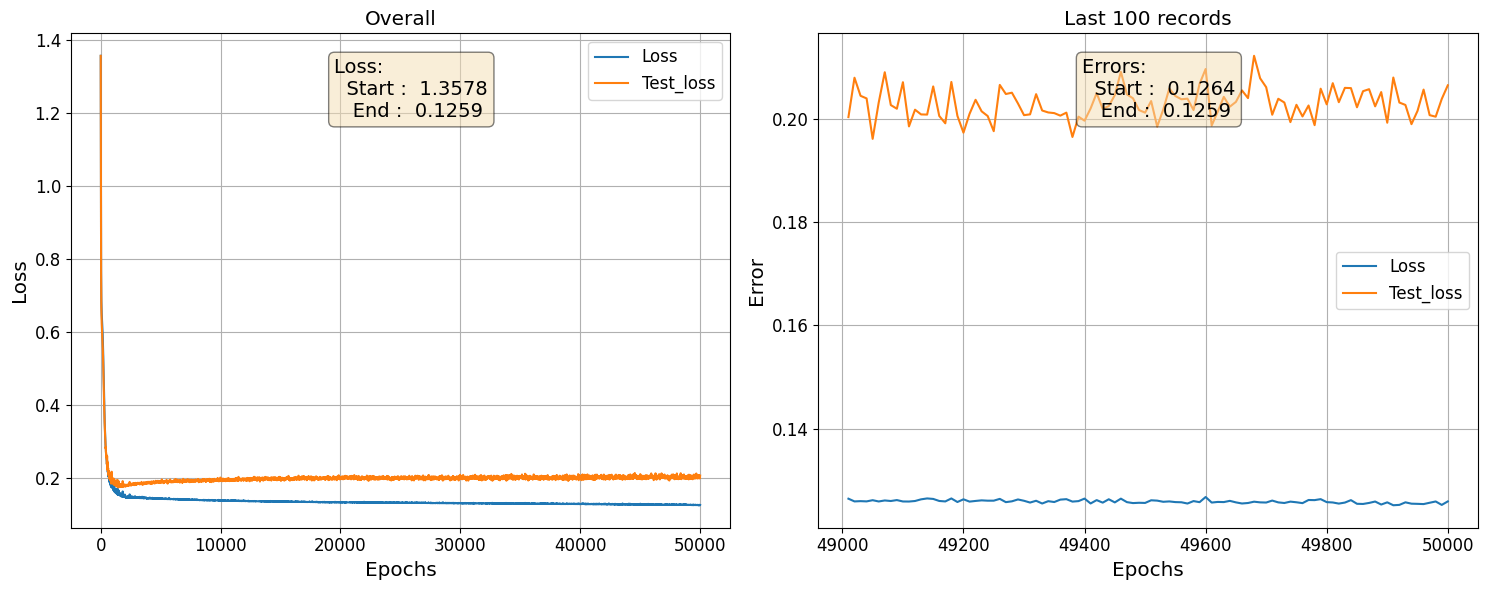

In [35]:
loss_df = pd.DataFrame(loss_hist)

fig, axes = plt.subplots(1,2 , figsize = (15,6))

l_range = 100

ax = axes[0]

loss_df.plot(x = 'epoch', y = ['Loss', 'Test_loss'], ax = ax)
loss = loss_df['Loss'].values

# little beautification
txtstr = "Loss: \n  Start : {:7.4f}\n   End : {:7.4f}".format(loss[0],loss[-1]) #text to plot
# properties  matplotlib.patch.Patch 
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords

ax.text(0.4, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_title('Overall')
ax.grid()

ax = axes[1]

loss_df[-l_range:].plot(x = 'epoch', y = ['Loss', 'Test_loss'], ax = ax)

# little beautification
txtstr = "Errors: \n  Start : {:7.4f}\n   End : {:7.4f}".format(loss[-l_range],loss[-1]) #text to plot
# properties  matplotlib.patch.Patch 
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords

ax.text(0.4, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Error")
ax.set_title('Last {} records'.format(l_range))
ax.grid()
plt.tight_layout()